<a href="https://colab.research.google.com/github/usamabinqasimdata-ops/Conditional-VAE-for-CelebA-Image-Manipulation/blob/main/Conditional_VAE_for_CelebA_Image_Manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **This notebook demonstrates how to build and train a Conditional Variational Autoencoder (CVAE) model using TensorFlow and the CelebA dataset. The CVAE can be used to generate images with specific attributes and modify existing images by changing their attributes.**

In [7]:
pip install tensorflow

This cell uses the `kagglehub` library to download the CelebA dataset. The dataset contains celebrity images and their attributes. The downloaded dataset is stored locally, and the path to the dataset files is printed.

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'celeba-dataset' dataset.
Path to dataset files: /kaggle/input/celeba-dataset


This cell reads the `list_attr_celeba.csv` file from the downloaded dataset into a pandas DataFrame. This CSV file contains the attribute labels for each image in the dataset. The first few rows of the DataFrame are displayed to show the data structure.

In [9]:
import pandas as pd
df = pd.read_csv(path + "/list_attr_celeba.csv")
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


This cell replaces all occurrences of `-1` with `0` in the DataFrame. The attribute labels in the dataset are originally represented as `1` and `-1`. Replacing `-1` with `0` makes the attributes binary (1 for present, 0 for absent), which is suitable for the model. The first few rows of the modified DataFrame are displayed.

In [10]:
df.replace(-1, 0, inplace=True)
display(df.head())

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


This cell imports the necessary libraries from TensorFlow and other modules for building and training the CVAE model. This includes layers for the neural network, model building functions, loss functions, and utilities for data handling and visualization.

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Lambda, concatenate, Dropout, Input, Conv2DTranspose
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import argparse

This cell loads and preprocesses a subset of the images from the CelebA dataset. It defines a function `load_and_preprocess_image` to read, resize, convert to RGB, and normalize images. It then applies this function to a specified number of images and stores them in a NumPy array. The shape of the processed images array and a sample image are displayed.

# **I am using 500 images to train the model.**

# **You can increase the number of images to make a better model.**

`num_images_to_process = 500`

Shape of processed images: (500, 128, 128, 3)


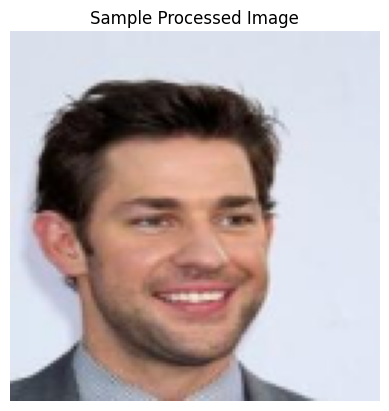

In [12]:
image_dir = path + "/img_align_celeba/img_align_celeba"
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]

def load_and_preprocess_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0 # Normalize to [0, 1]
    return img

# Load and preprocess a subset of images to demonstrate
# Loading all images might take a long time and memory
num_images_to_process = 500
processed_images = []
for i, image_file in enumerate(image_files[:num_images_to_process]):
    processed_images.append(load_and_preprocess_image(image_file))

processed_images = np.array(processed_images)

print(f"Shape of processed images: {processed_images.shape}")

# Display a sample processed image
plt.imshow(processed_images[0])
plt.title("Sample Processed Image")
plt.axis('off')
plt.show()

This cell defines the architecture of the Conditional Variational Autoencoder (CVAE) model. It includes functions to build the encoder and decoder networks. The encoder takes an image and its attributes as input and outputs the mean and log-variance of the latent space. The decoder takes a latent vector and attributes as input and reconstructs the image. A custom `CVAE` class is defined to combine the encoder and decoder and implement the training step with the VAE loss function (reconstruction loss and KL divergence). The model is then instantiated and compiled.

In [13]:

# Encoder
def build_encoder(input_shape, latent_dim, num_attributes):
    encoder_input = Input(shape=input_shape, name='encoder_input')
    attribute_input = Input(shape=(num_attributes,), name='attribute_input')

    x = Conv2D(32, kernel_size=3, activation='relu', strides=2, padding='same')(encoder_input)
    x = Conv2D(64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = Conv2D(128, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    conv_shape = K.int_shape(x)
    flattened_size = conv_shape[1] * conv_shape[2] * conv_shape[3]

    x = Flatten()(x)
    x = concatenate([x, attribute_input])
    x = Dense(256, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Return the encoder model and the calculated sizes separately
    encoder_model = Model([encoder_input, attribute_input], [z_mean, z_log_var], name='encoder')
    return encoder_model, flattened_size, conv_shape

# Sampling layer
@tf.function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Decoder
def build_decoder(latent_dim, num_attributes, original_image_size, flattened_size, conv_shape):
    decoder_input = Input(shape=(latent_dim,), name='decoder_input')
    attribute_input_decoder = Input(shape=(num_attributes,), name='attribute_input_decoder')

    x = concatenate([decoder_input, attribute_input_decoder])
    x = Dense(flattened_size, activation='relu')(x)
    x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
    x = Conv2DTranspose(128, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(64, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, kernel_size=3, activation='relu', strides=2, padding='same')(x)
    decoder_output = Conv2DTranspose(3, kernel_size=3, activation='sigmoid', padding='same')(x)

    return Model([decoder_input, attribute_input_decoder], decoder_output, name='decoder')

# Custom CVAE Model
class CVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        image_input, attribute_input = inputs
        z_mean, z_log_var = self.encoder([image_input, attribute_input]) # Encoder returns only z_mean and z_log_var
        z = sampling([z_mean, z_log_var])
        reconstructed_image = self.decoder([z, attribute_input])
        return reconstructed_image, z_mean, z_log_var

    def train_step(self, data):
        # Unpack the data. Our data is a tuple of (inputs, targets).
        # In VAE, inputs are also the targets for reconstruction.
        inputs, _ = data
        image_input, attribute_input = inputs

        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder([image_input, attribute_input]) # Encoder returns only z_mean and z_log_var
            z = sampling([z_mean, z_log_var])
            reconstructed_image = self.decoder([z, attribute_input])

            # Calculate reconstruction loss (binary cross-entropy)
            reconstruction_loss = binary_crossentropy(K.flatten(image_input), K.flatten(reconstructed_image))
            reconstruction_loss *= tf.cast(tf.reduce_prod(tf.shape(image_input)[1:]), dtype=tf.float32) # Scale by image dimensions
            reconstruction_loss = tf.reduce_mean(reconstruction_loss)

            # Calculate KL divergence loss
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
            kl_loss = tf.reduce_mean(kl_loss)

            # Total VAE loss
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


# Define parameters
input_shape = (128, 128, 3)  # Image size
latent_dim = 100 # Latent space dimensionality
num_attributes = df.shape[1] - 1 # Number of attributes (excluding image_id)
original_image_size = (128, 128, 3)

# Build the base encoder and decoder models
encoder_base, flattened_size, conv_shape = build_encoder(input_shape, latent_dim, num_attributes)
decoder_base = build_decoder(latent_dim, num_attributes, original_image_size, flattened_size, conv_shape) # Pass flattened_size and conv_shape

# Instantiate the custom CVAE model
cvae = CVAE(encoder_base, decoder_base)

# Compile the CVAE model
cvae.compile(optimizer=tf.keras.optimizers.Adam()) # Optimizer is required, loss is calculated in train_step

cvae.summary()

Model: "cvae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 100), (None,   │     8,543,752 │
│                                 │ 100))                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 128, 128, 3)    │     4,860,995 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,404,747 (51.14 MB)

 Trainable params: 13,404,747 (51.14 MB)

 Non-trainable params: 0 (0.00 B)

This cell prepares the data for training the CVAE model. It extracts the filenames of the processed images and filters the attribute DataFrame to include only the attributes for these images. It then ensures the order of attributes matches the order of processed images. Finally, it sets the batch size and number of epochs for training and trains the CVAE model using the processed images and their corresponding attributes.

In [14]:
# Prepare data for training
# For demonstration, using the small subset of processed images and corresponding attributes
# In a real scenario with the full dataset, use a data generator or tf.data

# Get the image filenames from the processed images
processed_image_filenames = [os.path.basename(f) for f in image_files[:num_images_to_process]]

# Filter the dataframe to get attributes for the processed images
attributes_for_processed_images = df[df['image_id'].isin(processed_image_filenames)].drop(columns=['image_id']).values

# Ensure the order of attributes matches the order of processed images
# Create a dictionary from the dataframe for quick lookup
attribute_dict = df.set_index('image_id').T.to_dict('list')

# Reorder attributes based on the processed image filenames
ordered_attributes = []
for filename in processed_image_filenames:
    ordered_attributes.append(attribute_dict[filename])

ordered_attributes = np.array(ordered_attributes)


# Train the CVAE model
batch_size = 256
epochs = 400

# Using the small subset of processed images and attributes
# Note: Batch size might be larger than the number of samples for this small subset.
# In a real scenario, ensure batch_size <= number of samples.
# Adjusting batch_size for the small subset
if batch_size > len(processed_images):
    batch_size = len(processed_images)

print(f"Training with batch size: {batch_size} and epochs: {epochs}")

history = cvae.fit(
    [processed_images, ordered_attributes],
    processed_images, # VAE loss uses the input as the target for reconstruction
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True
)

print("Training finished.")

Training with batch size: 256 and epochs: 400
Epoch 1/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 43s 19s/step - kl_loss: 3.2937 - loss: 34061.1680 - reconstruction_loss: 34057.8750
Epoch 2/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - kl_loss: 0.0421 - loss: 33991.4141 - reconstruction_loss: 33991.3711
Epoch 3/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - kl_loss: 0.0098 - loss: 33836.8008 - reconstruction_loss: 33836.7891
Epoch 4/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - kl_loss: 0.0597 - loss: 33521.1367 - reconstruction_loss: 33521.0742
Epoch 5/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - kl_loss: 0.5369 - loss: 33257.2734 - reconstruction_loss: 33256.7344
Epoch 6/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - kl_loss: 0.1539 - loss: 33212.7539 - reconstruction_loss: 33212.5977
Epoch 7/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - kl_loss: 0.0889 - loss: 32974.5859 - reconstruction_loss: 32974.4961
Epoch 8/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - kl_loss: 0.4584 - loss: 32934.7500 - reconstruct

This cell tests the trained CVAE model by reconstructing a sample image. It selects the first processed image and its attributes, uses the `cvae.predict` method to get the reconstructed image, and then displays the original and reconstructed images side by side using `matplotlib`.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


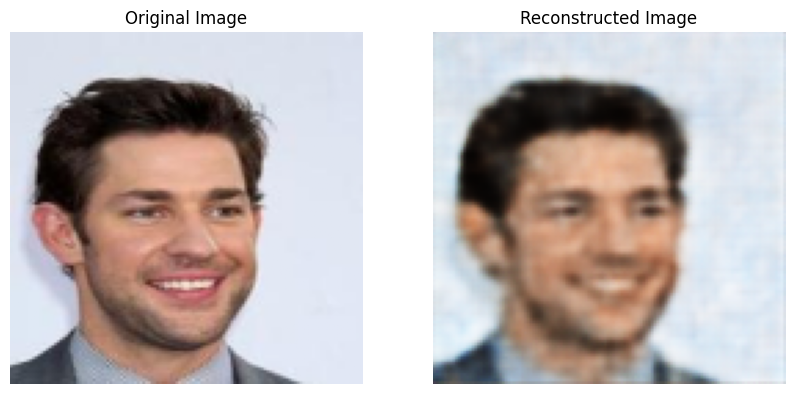

Image reconstruction test finished.


In [15]:
# Test the trained CVAE by reconstructing an image

# Select a sample image and its attributes from the processed data
# Using the first processed image and its corresponding attributes
sample_image = processed_images[0:1] # Keep batch dimension
sample_attributes = ordered_attributes[0:1] # Keep batch dimension

# Get the reconstructed image from the CVAE model
# The model returns (reconstructed_image, z_mean, z_log_var), so we take the first element
reconstructed_image, _, _ = cvae.predict([sample_image, sample_attributes])

# Display the original and reconstructed images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(sample_image[0])
plt.title("Original Image")
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image[0])
plt.title("Reconstructed Image")
plt.axis('off')

plt.show()

print("Image reconstruction test finished.")

**For better results, reduce batch size and increase epochs.**

This cell demonstrates how to use the trained CVAE to modify attributes of an image. It selects a target image and defines a dictionary of attributes to modify. It then retrieves the original image and its attributes, modifies the specified attributes, and uses the encoder to get the latent representation of the original image. Finally, it uses the decoder to reconstruct the image with the modified attributes and displays the original and modified images.

Attempting to modify attributes for image '083648.jpg'.
Found 083648.jpg at index 0 in the processed subset.
Original attributes for 083648.jpg: [1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 1]
Modified attribute 'Mustache' to 1 (index 22).
Modified attribute 'Young' to 0 (index 39).
Modified attributes: [1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


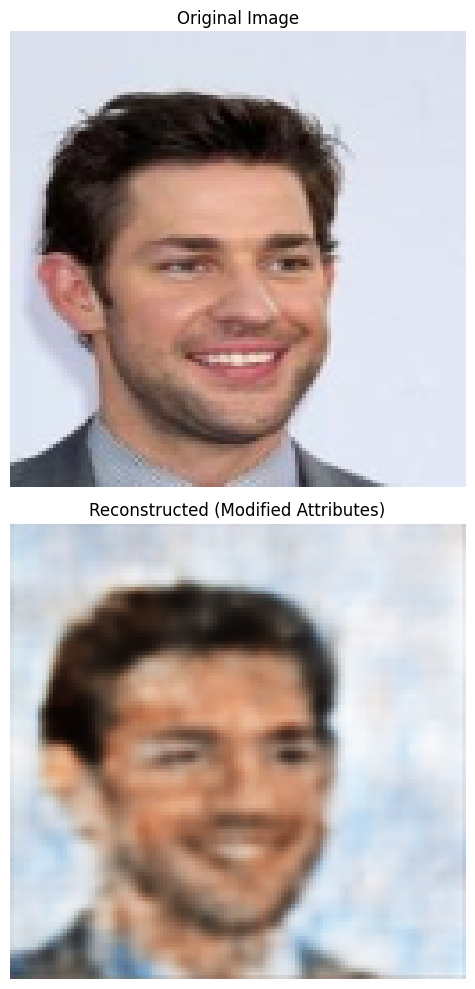

Image reconstruction with modified attributes finished.


In [16]:
# Reconstruct an image with modified attributes

# Define the target image filename and the attributes to modify
# Change these variables to experiment with different images and attributes
target_image_filename = processed_image_filenames[0] # Use the first processed image as default
attributes_to_modify = {
    'Mustache': 1,
    'Young': 0
}

print(f"Attempting to modify attributes for image '{target_image_filename}'.")

# Find the index of the target image in the processed images and filenames
try:
    image_index = processed_image_filenames.index(target_image_filename)
    print(f"Found {target_image_filename} at index {image_index} in the processed subset.")
except ValueError:
    print(f"'{target_image_filename}' not found in the current processed subset. Loading and preprocessing this specific image.")
    # Construct the full path to the target image
    target_image_path = os.path.join(image_dir, target_image_filename)
    if os.path.exists(target_image_path):
        # Load and preprocess the target image
        target_image_processed = load_and_preprocess_image(target_image_path)
        # Add the processed image and its filename to the lists
        # Use np.append for arrays and list.append for lists
        processed_images = np.append(processed_images, [target_image_processed], axis=0)
        processed_image_filenames.append(target_image_filename)

        # Get the attributes for the target image from the full dataframe
        target_attributes = df[df['image_id'] == target_image_filename].drop(columns=['image_id']).values
        # Add the attributes to the ordered_attributes list
        ordered_attributes = np.append(ordered_attributes, target_attributes, axis=0)


        # Find the index of the newly added image
        image_index = processed_image_filenames.index(target_image_filename)
        print(f"'{target_image_filename}' loaded and added at index {image_index}.")
    else:
        print(f"Error: Image file '{target_image_filename}' not found in the directory '{image_dir}'.")
        image_index = -1 # Indicate not found


if image_index != -1:
    # Get the original image and its attributes
    original_image = processed_images[image_index:image_index+1] # Keep batch dimension
    original_attributes = ordered_attributes[image_index:image_index+1].copy() # Keep batch dimension and create a copy to modify

    # Get the index of the attributes to modify and modify the values
    modified_attributes = original_attributes.copy()
    attribute_columns = df.columns.tolist()
    attribute_columns.remove('image_id')
    modification_successful = True
    print("Original attributes for {}: {}".format(target_image_filename, original_attributes[0]))

    for attr, value in attributes_to_modify.items():
        try:
            attribute_index = attribute_columns.index(attr)
            modified_attributes[0, attribute_index] = value
            print(f"Modified attribute '{attr}' to {value} (index {attribute_index}).")
        except ValueError:
            print(f"Error: Attribute '{attr}' not found in the dataframe columns.")
            modification_successful = False
            break # Stop if any attribute is not found

    if modification_successful:
        print(f"Modified attributes: {modified_attributes[0]}")

        # Get the latent space representation (z_mean and z_log_var) for the original image
        # from the encoder
        z_mean, z_log_var = cvae.encoder.predict([original_image, original_attributes])

        # Sample a latent vector from the distribution defined by z_mean and z_log_var
        z_sampled = sampling([z_mean, z_log_var])

        # Reconstruct the image using the decoder with the sampled latent vector and MODIFIED attributes
        reconstructed_image_modified = cvae.decoder.predict([z_sampled, modified_attributes])

        # Display the original and reconstructed (with modified attributes) images vertically
        plt.figure(figsize=(8, 10)) # Adjust figure size for vertical display

        # Original Image
        plt.subplot(2, 1, 1) # 2 rows, 1 column, 1st plot
        plt.imshow(original_image[0])
        plt.title("Original Image")
        plt.axis('off')

        # Reconstructed Image (Modified Attributes)
        plt.subplot(2, 1, 2) # 2 rows, 1 column, 2nd plot
        plt.imshow(reconstructed_image_modified[0])
        plt.title(f"Reconstructed (Modified Attributes)")
        plt.axis('off')

        plt.tight_layout() # Adjust layout to prevent titles overlapping
        plt.show()

        print("Image reconstruction with modified attributes finished.")
    else:
        print("Could not proceed with attribute modification due to attribute not found.")
else:
    print("Could not proceed with image reconstruction.")